# RBE549 Visual Odometry Project
## Authors: Justin Hall and Leonardo Puerto

### Initial Python Code and Module Import
For the main Visual Odometry functionality we import OpenCV, Scipy, and Numpy. Time is imported to allow the ability to time how long it takes to process the 51 stereo image samples based on different configurations. tqdm is imported to visually represent image processing over time. Nicolai Nielsen's plotting and video visualization code was imported to show the string of images that will be processed as well as the ground truth vs estimage positions and errors. 

In [4]:
import os
import numpy as np
import cv2
from scipy.optimize import least_squares
import time
import sys
import PySimpleGUI as sg

from lib.visualization.plotting import visualize_paths
from lib.visualization.video import play_trip
import stereo_visual_odometry as VO_original
import RBE549_Jupyter_Code_Callable as VO_test

from tqdm import tqdm

### Code Configuration Controls
The below section allows the code to be modified for different configurations that effect the effeciency and processing time of the Visual Odometry code.

#### Animation
If the variale 'animate' is set to 0, all visualizations will be skipped, but the postion data will still be stored. When 'animate' is set to 1 the string of stereo images will be played, the postion and error plots will be shown, and the progress bar will be displayed in the terminal.

In [5]:
"""
animate:
0 - No videos or plots
1 - Show videos and plots
"""
animate = 1

#### Stereo Disperity Map Options

Two algorithms in OpenCV are used to generate our disparity maps. OpenCV has a Semi-Global Block Matching and standard Block Matching algorithm. Block matching compares the sum of the adsolute differences (SAD) of each block while the Semi-Global Block Matching forces similar disparities on neighboring blocks. A reference for each is listed below:

Block-matching algorithm: https://en.wikipedia.org/wiki/Block-matching_algorithm

Semi-global matching: https://en.wikipedia.org/wiki/Semi-global_matching


In [6]:
'''
stereo:
1 - StereoSGBM_create
2 - StereoBM_create
'''
stereo_options = [0,'StereoSGBM_create','StereoBM_create']
stereo = 1

### Feature Detection Options

Three OpenCV algorithms are used to identify feature keypoints. FAST, SIFT, and ORB were used for comparison based on the processing time and accuracy benifits. A reference for each is listed below:

Features from Accelerated Segment Test (FAST): https://en.wikipedia.org/wiki/Features_from_accelerated_segment_test

Scale-Invariant Feature Transform (SIFT): https://en.wikipedia.org/wiki/Scale-invariant_feature_transform

Oriented FAST and Rotated BRIEF (ORB): https://en.wikipedia.org/wiki/Oriented_FAST_and_rotated_BRIEF


In [7]:
'''
feature:
1 - FastFeatureDetector_create
2 - SIFT_create
3 - ORB_create
'''
feature_options = [0,'FastFeatureDetector_create','SIFT_create','ORB_create' ]
feature = 1

### Optical Flow Options

Two sparse optical flow algorithms were attemted to be used, Pyrimad Lucas-Kanade and sparse Robust Local Optical Flow. Even though both algorithms take in the same inputs and generates the same outputs, there are some differences that cause issues with code operations. For now the sparse RLOF is under construction.

Lucas–Kanade method: https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method

Robust Local Optical Flow: TBD

In [8]:
'''
optical:
1 - calcOpticalFlowPyrLK
2 - calcOpticalFlowSparseRLOF
'''
optical_options = [0,'calcOpticalFlowPyrLK','calcOpticalFlowSparseRLOF']
optical = 1

### Camera Calibration Parameters

For this comparison code the camera calibration parameters come from the KITTI data set 'calib.txt' file. 

$$P_l = \begin{bmatrix}
718.856 & 0 & 607.1928 & 0\\
0 & 718.856 & 185.2157 & 0\\
0 & 0 & 1 & 0
\end{bmatrix} \; \; \; and \; \; \; P_r =  \begin{bmatrix}
718.856 & 0 & 607.1928 & -386.1448\\
0 & 718.856 & 185.2157 & 0\\
0 & 0 & 1 & 0
\end{bmatrix}$$

For the real-time test code, new calibration parameters will be required specific for the stereo camera. A seperate calibration code will be used for this function.

In [10]:
global P_l, K_l, P_r, K_r 

data_dir = 'KITTI_sequence_2'  # Try KITTI_sequence_2

with open(data_dir + '/calib.txt', 'r') as f:
        params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
        P_l = np.reshape(params, (3, 4))
        K_l = P_l[0:3, 0:3]
        params = np.fromstring(f.readline(), dtype=np.float64, sep=' ')
        P_r = np.reshape(params, (3, 4))
        K_r = P_r[0:3, 0:3]


### Ground Truth Positional Data

The ground truth positional data is gathered directly from the KITTI dataset and extracted to use for our accuracy comparison.

In [11]:
gt_poses = []
with open(data_dir + '/poses.txt', 'r') as f:
    for line in f.readlines():
        T = np.fromstring(line, dtype=np.float64, sep=' ')
        T = T.reshape(3, 4)
        T = np.vstack((T, [0, 0, 0, 1]))
        gt_poses.append(T)


### Image Data

The below section pulls in the left and right camera image sequences from the KITTI dataset. For the real-time application the images will be pulled from the stereo camera once the previous positional estimation is completed. 

In [12]:
global images_l, images_r

image_paths = [os.path.join(data_dir + '/image_l', file) for file in sorted(os.listdir(data_dir + '/image_l'))]
images_l = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]

image_paths = [os.path.join(data_dir + '/image_r', file) for file in sorted(os.listdir(data_dir + '/image_r'))]
images_r = [cv2.imread(path, cv2.IMREAD_GRAYSCALE) for path in image_paths]


### Disparity Map Creation
This sectoin covers the parameters required to setup and create the disparity maps. 

#### StereoSGBM
Semi-Global Block Matching we used originally but the parameters were changed for this code to improve the accuracy of the Visual Odometry output. The reference for the parameters can be found in the OpenCV documentation at https://docs.opencv.org/3.4/d2/d85/classcv_1_1StereoSGBM.html. The first change we made was to the block size from 11 to 15 which effects the block window size and the smoothing parameters P1 and P2. We increased the number of disparities from 32 to 256 (this parameter must be divisible by 16). We change the uniqueness ratio away from default of zero to 5 based on the documentation suggested a value of 5-15 should be adequate for good results. Finally, we adjusted the speckle window size and range. Suggested values for these, if used, was recommended to be within 50 and 200 for window size and 1 or 2 for range. For this we did some trial and error to find the best results for accuracy which was 200 for window size and 2 for range. All of these changes did have a benificial reaction on accuracy, but at the cost of processing speed.

#### StereoBM
Block matching is a has much simpler input parameters. hte reference for the parameters can be found in the OpenCV documentation at https://docs.opencv.org/3.4/d9/dba/classcv_1_1StereoBM.html. Some trial and error was done to find the best parameters for accuracy. We found that the 80 disparities and a block size of 9 to give the best results for our sample KITTI dataset. 

In [13]:
global disparity, disparities

if stereo == 1:
    # For explication of rows 20 - 31 use https://www.andreasjakl.com/how-to-apply-stereo-matching-to-generate-depth-maps-part-3/ and https://docs.opencv.org/4.5.0/d2/d85/classcv_1_1StereoSGBM.html
    block = 15

    SGBM_params = dict(minDisparity = 0, 
                        numDisparities = 256, 
                        blockSize = block,
                        uniquenessRatio = 5, 
                        speckleWindowSize = 200, 
                        speckleRange = 2, 
                        disp12MaxDiff = 0,
                        P1 = block * block * 8,
                        P2 = block * block * 32)
    
    disparity = cv2.StereoSGBM_create(**SGBM_params)

    disparities = [np.divide(disparity.compute(images_l[0], images_r[0]).astype(np.float32), 16)]
    
elif stereo == 2:

    BM_params = dict(numDisparities = 16*5, 
                            blockSize = 9)

    disparity = cv2.StereoBM_create(**BM_params)

    disparities = [np.divide(disparity.compute(images_l[0], images_r[0]).astype(np.float32), 16)]
else:
    test_layout = [[sg.Text('Invalid Stereo Input. Only 1 and 2 are valid.         ')],
           [sg.Button('Exit')]]

    test_window2 = sg.Window('Error Message', test_layout)
    while True:
        event, values = test_window2.read()
        if event in (None, 'Exit'):
            test_window2.Close()
            sys.exit()   

### Keypoint Feature Detector Creation

#### FAST
https://docs.opencv.org/3.4/df/d74/classcv_1_1FastFeatureDetector.html

#### SIFT
https://docs.opencv.org/3.4/d7/d60/classcv_1_1SIFT.html

#### ORB
https://docs.opencv.org/3.4/db/d95/classcv_1_1ORB.html


In [14]:
global fastFeatures

if feature == 1:
    # This article could be a good source to improve feature detecion: https://blog.francium.tech/feature-detection-and-matching-with-opencv-5fd2394a590
    fastFeatures = cv2.FastFeatureDetector_create()

elif feature == 2:
    fastFeatures = cv2.SIFT_create()

elif feature == 3:
    fastFeatures = cv2.ORB_create()

else:
    test_layout = [[sg.Text('Invalid Feature Input. Only 1, 2, and 3 are valid.         ')],
           [sg.Button('Exit')]]

    test_window2 = sg.Window('Error Message', test_layout)
    while True:
        event, values = test_window2.read()
        if event in (None, 'Exit'):
            test_window2.Close()
            sys.exit() 

### Optical Flow Parameters

#### Lucas–Kanade
https://docs.opencv.org/3.4/dc/d6b/group__video__track.html#ga473e4b886d0bcc6b65831eb88ed93323

#### Sparse RLOF
https://docs.opencv.org/4.x/d4/d91/classcv_1_1optflow_1_1RLOFOpticalFlowParameter.html



In [15]:
global opti_params

if optical==1:
    # LK
    opti_params = dict(winSize=(15, 15),
                    flags=cv2.MOTION_AFFINE,
                    maxLevel=3,
                    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.03))
elif optical==2:  
    # RLOF
    opti_params = cv2.optflow.RLOFOpticalFlowParameter_create()
    opti_params.setMaxIteration(30)
    opti_params.setNormSigma0(3.2)
    opti_params.setNormSigma1(7.0)
    opti_params.setLargeWinSize(21)
    opti_params.setSmallWinSize(9)
    opti_params.setMaxLevel(9)
    opti_params.setMinEigenValue(0.0001)
    opti_params.setCrossSegmentationThreshold(25)
    opti_params.setGlobalMotionRansacThreshold(10.0)

    test_layout = [[sg.Text('Option still under construction.             \nDo you want to continue?')],
           [sg.Button('Continue'),sg.Button('Exit')]]

    test_window2 = sg.Window('Warning Message', test_layout)
    while True:
        event, values = test_window2.read()
        if event in (None, 'Exit'):
            test_window2.Close()
            sys.exit() 
        if event in (None, 'Continue'):
            test_window2.Close()
            break

else:
    test_layout = [[sg.Text('Invalid Optical Input. Only 1 and 2 are valid.         ')],
           [sg.Button('Exit')]]

    test_window2 = sg.Window('Error Message', test_layout)
    while True:
        event, values = test_window2.read()
        if event in (None, 'Exit'):
            test_window2.Close()
            sys.exit() 

### Optical Flow
The track_keypoints function tracks keypoints from frames over time. This funciton takes the current keypoints from the first image and track them in the next frame in time. The status output from the optical flow function is used to identify which points are trackable reduces the number of tracked keypoints in the current and previous images. The tracked keypoints are further reduced based on if the error is within the max error threshold and within in the bounds of the image. 

In [16]:
def track_keypoints(img1, img2, kp1, optical, max_error=4):
    """
    Tracks the keypoints between frames

    Parameters
    ----------
    img1 (ndarray): i-1'th image. Shape (height, width)
    img2 (ndarray): i'th image. Shape (height, width)
    kp1 (ndarray): Keypoints in the i-1'th image. Shape (n_keypoints)
    max_error (float): The maximum acceptable error

    Returns
    -------
    trackpoints1 (ndarray): The tracked keypoints for the i-1'th image. Shape (n_keypoints_match, 2)
    trackpoints2 (ndarray): The tracked keypoints for the i'th image. Shape (n_keypoints_match, 2)
    """
    # Convert the keypoints into a vector of points and expand the dims so we can select the good ones
    trackpoints1 = np.expand_dims(cv2.KeyPoint_convert(kp1), axis=1)

    if optical == 1:
        # Use optical flow to find tracked counterparts
        trackpoints2, st, err = cv2.calcOpticalFlowPyrLK(img1, img2, trackpoints1, None, **opti_params)

    elif optical == 2:
        # Use optical flow to find tracked counterparts
        img1_cvt = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
        img2_cvt = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
        trackpoints2, st, err = cv2.optflow.calcOpticalFlowSparseRLOF(img1_cvt, img2_cvt, trackpoints1, None, rlofParam = opti_params)

    # Convert the status vector to boolean so we can use it as a mask
    trackable = st.astype(bool)

    # Create a maks there selects the keypoints there was trackable and under the max error
    under_thresh = np.where(err[trackable] < max_error, True, False)

    # Use the mask to select the keypoints
    trackpoints1 = trackpoints1[trackable][under_thresh]
    trackpoints2 = np.around(trackpoints2[trackable][under_thresh])

    # Remove the keypoints there is outside the image
    h, w = img1.shape
    in_bounds = np.where(np.logical_and(trackpoints2[:, 1] < h, trackpoints2[:, 0] < w), True, False)
    trackpoints1 = trackpoints1[in_bounds]
    trackpoints2 = trackpoints2[in_bounds]

    return trackpoints1, trackpoints2

### Overall Feature Points
The calculate_right_qs function takes in the filtered key points from the previous section as well as the disparity outputs from the current and previous left/right image combinaitons. The masks identify the areas wihtin the range of the minimum and maximum disparities. These masks are used to identify what is considered in bounds for the left image keypoints and disparities. The right image keypoints are defined by the left image keypoints minus the disparities. 

In [17]:
def calculate_right_qs(q1, q2, disp1, disp2, min_disp=0.0, max_disp=100.0):
    """
    Calculates the right keypoints (feature points)

    Parameters
    ----------
    q1 (ndarray): Feature points in i-1'th left image. In shape (n_points, 2)
    q2 (ndarray): Feature points in i'th left image. In shape (n_points, 2)
    disp1 (ndarray): Disparity i-1'th image per. Shape (height, width)
    disp2 (ndarray): Disparity i'th image per. Shape (height, width)
    min_disp (float): The minimum disparity
    max_disp (float): The maximum disparity

    Returns
    -------
    q1_l (ndarray): Feature points in i-1'th left image. In shape (n_in_bounds, 2)
    q1_r (ndarray): Feature points in i-1'th right image. In shape (n_in_bounds, 2)
    q2_l (ndarray): Feature points in i'th left image. In shape (n_in_bounds, 2)
    q2_r (ndarray): Feature points in i'th right image. In shape (n_in_bounds, 2)
    """
    def get_idxs(q, disp):
        q_idx = q.astype(int)
        disp = disp.T[q_idx[:, 0], q_idx[:, 1]]
        return disp, np.where(np.logical_and(min_disp < disp, disp < max_disp), True, False)
    
    # Get the disparity's for the feature points and mask for min_disp & max_disp
    disp1, mask1 = get_idxs(q1, disp1)
    disp2, mask2 = get_idxs(q2, disp2)
    
    # Combine the masks 
    in_bounds = np.logical_and(mask1, mask2)
    
    # Get the feature points and disparity's there was in bounds
    q1_l, q2_l, disp1, disp2 = q1[in_bounds], q2[in_bounds], disp1[in_bounds], disp2[in_bounds]
    
    # Calculate the right feature points 
    q1_r, q2_r = np.copy(q1_l), np.copy(q2_l)
    q1_r[:, 0] -= disp1
    q2_r[:, 0] -= disp2
    
    return q1_l, q1_r, q2_l, q2_r

### Points for Triangulation
The calc_3d function takes the overall feature points and the projection matrices for the left and right cameras. Using these inputs and the triangulation function in OpenCV to generate the 3D points in the current and previous image pairs.

In [18]:
def calc_3d(q1_l, q1_r, q2_l, q2_r):
        """
        Triangulate points from both images 
        
        Parameters
        ----------
        q1_l (ndarray): Feature points in i-1'th left image. In shape (n, 2)
        q1_r (ndarray): Feature points in i-1'th right image. In shape (n, 2)
        q2_l (ndarray): Feature points in i'th left image. In shape (n, 2)
        q2_r (ndarray): Feature points in i'th right image. In shape (n, 2)

        Returns
        -------
        Q1 (ndarray): 3D points seen from the i-1'th image. In shape (n, 3)
        Q2 (ndarray): 3D points seen from the i'th image. In shape (n, 3)
        """
        # Triangulate points from i-1'th image
        Q1 = cv2.triangulatePoints(P_l, P_r, q1_l.T, q1_r.T)
        # Un-homogenize
        Q1 = np.transpose(Q1[:3] / Q1[3])

        # Triangulate points from i'th image
        Q2 = cv2.triangulatePoints(P_l, P_r, q2_l.T, q2_r.T)
        # Un-homogenize
        Q2 = np.transpose(Q2[:3] / Q2[3])

        return Q1, Q2

### Estimated Transformation Matrix
The form_transf function generates a transformation matrix from the inputed rotatoinal matrix and translational matrix from the least square output in a later section.

In [19]:
def form_transf(R, t):
    """
    Makes a transformation matrix from the given rotation matrix and translation vector

    Parameters
    ----------
    R (ndarray): The rotation matrix. Shape (3,3)
    t (list): The translation vector. Shape (3)

    Returns
    -------
    T (ndarray): The transformation matrix. Shape (4,4)
    """
    T = np.eye(4, dtype=np.float64)
    T[:3, :3] = R
    T[:3, 3] = t

    return T

### Projection Error
The reprojection_residuals function takes in the a set of 6 random feature points and their associated key triangulation points, as well as the left/right camera projection matrices. This function predicts a transformation and projection matrices based on the dof input and camera procection matices. This function outputs the error residuals based on the deference of the predicted and actual feature points.

In [20]:
def reprojection_residuals(dof, q1, q2, Q1, Q2):
        """
        Calculate the residuals

        Parameters
        ----------
        dof (ndarray): Transformation between the two frames. First 3 elements are the rotation vector and the last 3 is the translation. Shape (6)
        q1 (ndarray): Feature points in i-1'th image. Shape (n_points, 2)
        q2 (ndarray): Feature points in i'th image. Shape (n_points, 2)
        Q1 (ndarray): 3D points seen from the i-1'th image. Shape (n_points, 3)
        Q2 (ndarray): 3D points seen from the i'th image. Shape (n_points, 3)

        Returns
        -------
        residuals (ndarray): The residuals. In shape (2 * n_points * 2)
        """
        # Get the rotation vector
        r = dof[:3]
        # Create the rotation matrix from the rotation vector
        R, _ = cv2.Rodrigues(r)
        # Get the translation vector
        t = dof[3:]
        # Create the transformation matrix from the rotation matrix and translation vector
        transf = form_transf(R, t)

        # Create the projection matrix for the i-1'th image and i'th image
        f_projection = np.matmul(P_l, transf)
        b_projection = np.matmul(P_l, np.linalg.inv(transf))

        # Make the 3D points homogenize
        ones = np.ones((q1.shape[0], 1))
        Q1 = np.hstack([Q1, ones])
        Q2 = np.hstack([Q2, ones])

        # Project 3D points from i'th image to i-1'th image
        q1_pred = Q2.dot(f_projection.T)
        # Un-homogenize
        q1_pred = q1_pred[:, :2].T / q1_pred[:, 2]

        # Project 3D points from i-1'th image to i'th image
        q2_pred = Q1.dot(b_projection.T)
        # Un-homogenize
        q2_pred = q2_pred[:, :2].T / q2_pred[:, 2]

        # Calculate the residuals
        residuals = np.vstack([q1_pred - q1.T, q2_pred - q2.T]).flatten()
        
        return residuals

### Actual Transformation Matrix
The estimate_pose function takes in the current and previous image feature points, as well as the current and previous3D points as inputs. This function picks 6 random feature points and associated 3D points to pass into the residual function in the previous code set. The residual function is then used to do least square optimization and to establish errors and will be used for early termination of the optization loop. After the optimization loop the optimum rotational and translational matrices are combined into a new transformation matrix to be use to estimate the next postional point for visual odometry. 

In [21]:
def estimate_pose(q1, q2, Q1, Q2, max_iter=100):
    """
    Estimates the transformation matrix

    Parameters
    ----------
    q1 (ndarray): Feature points in i-1'th image. Shape (n, 2)
    q2 (ndarray): Feature points in i'th image. Shape (n, 2)
    Q1 (ndarray): 3D points seen from the i-1'th image. Shape (n, 3)
    Q2 (ndarray): 3D points seen from the i'th image. Shape (n, 3)
    max_iter (int): The maximum number of iterations

    Returns
    -------
    transformation_matrix (ndarray): The transformation matrix. Shape (4,4)
    """
    early_termination_threshold = 5

    # Initialize the min_error and early_termination counter
    min_error = float('inf')
    early_termination = 0

    for _ in range(max_iter):
        # Choose 6 random feature points
        sample_idx = np.random.choice(range(q1.shape[0]), 6)
        sample_q1, sample_q2, sample_Q1, sample_Q2 = q1[sample_idx], q2[sample_idx], Q1[sample_idx], Q2[sample_idx]

        # Make the start guess
        in_guess = np.zeros(6)
        # Perform least squares optimization
        opt_res = least_squares(reprojection_residuals, in_guess, method='lm', max_nfev=200,
                                args=(sample_q1, sample_q2, sample_Q1, sample_Q2))

        # Calculate the error for the optimized transformation
        error = reprojection_residuals(opt_res.x, q1, q2, Q1, Q2)
        error = error.reshape((Q1.shape[0] * 2, 2))
        error = np.sum(np.linalg.norm(error, axis=1))

        # Check if the error is less the the current min error. Save the result if it is
        if error < min_error:
            min_error = error
            out_pose = opt_res.x
            early_termination = 0
        else:
            early_termination += 1
        if early_termination == early_termination_threshold:
            # If we have not fund any better result in early_termination_threshold iterations
            break

    # Get the rotation vector
    r = out_pose[:3]
    # Make the rotation matrix
    R, _ = cv2.Rodrigues(r)
    # Get the translation vector
    t = out_pose[3:]
    # Make the transformation matrix
    transformation_matrix = form_transf(R, t)

    return transformation_matrix

### Positional Change
The get_pose function brings together all of the previous functions into a single callable to generate the transorfmation matrices. It takes in he iterable variable "i" that denotes the current frame of the KITTI dataset and the input of which optical flow method to use. This variable pulls the current and previous left camera images from the KITTI dataset. The previous left image is passed into the feature detector function to identify the image keypoints. The left current and previous images with the image keypoints aer passed into the keypoint tracker function that utilizes optical flow to identify the keypoints that are trackable between both images. The previous current left and right images are passed into the stereo function to identify the disparities between the two images. These disparities in conjunction with the trackable keypoins are passed in to the calculate_right_qs function to generate the feature points for all images in the set (left/right previous and left/right current). The feature points are then passed into the calc_3d function to geneate the triangulation points for the current and previous image pairs. Finaly the left image set feature points with the 3D triangulation points are passd to get the final transformation matrix. 

The original function 'get_tiled_keypoints' which broke up the image into tiles, and found keypoints per tile, had to be remove to allow for the use of other feature detectors. SIFT and ORB did not work with this tile break down and had to be removed to see if other feature detectors could improve the output results. 

In [22]:
def get_pose(i, optical):
    """
    Calculates the transformation matrix for the i'th frame

    Parameters
    ----------
    i (int): Frame index

    Returns
    -------
    transformation_matrix (ndarray): The transformation matrix. Shape (4,4)
    """
    # Get the i-1'th image and i'th image
    img1_l, img2_l = images_l[i - 1:i + 1]

    # Get teh tiled keypoints
    #kp1_l = get_tiled_keypoints(img1_l, 10, 20)
    kp1_l = fastFeatures.detect(img1_l)
    
    # Track the keypoints
    tp1_l, tp2_l = track_keypoints(img1_l, img2_l, kp1_l, optical)
    
    # Calculate the disparitie
    disparities.append(np.divide(disparity.compute(img2_l, images_r[i]).astype(np.float32), 16))

    # Calculate the right keypoints
    tp1_l, tp1_r, tp2_l, tp2_r = calculate_right_qs(tp1_l, tp2_l, disparities[i - 1], disparities[i])

    # Calculate the 3D points
    Q1, Q2 = calc_3d(tp1_l, tp1_r, tp2_l, tp2_r)

    # Estimate the transformation matrix
    transformation_matrix = estimate_pose(tp1_l, tp2_l, Q1, Q2)
    
    return transformation_matrix

### Video Play
This section will play all images in a sequence if the animate variable is set to 1.

In [23]:
if animate == 1:
    play_trip(images_l, images_r)  # Comment out to not play the trip

### Testing Over Multiple Samples
The below code is a loop to run a specified number of samples and print out the test configureation, the average processing time of the get_pose function, and average final error of all tests. This portion of the code is used to identify which test configuration will produce the best results with minimal processing time. 

In [24]:
samples = 1
times = []
errors = []
for k in range(samples):
    gt_path = []
    estimated_path = []

    if animate == 1:
        poses = enumerate(tqdm(gt_poses, unit="poses"))
    else:
        poses = enumerate(gt_poses)

    start = time.time()
    for i, gt_pose in poses:
        if i < 1:
            cur_pose = gt_pose
        else:
            transf = get_pose(i, optical)
            cur_pose = np.matmul(cur_pose, transf)
        gt_path.append((gt_pose[0, 3], gt_pose[2, 3]))
        estimated_path.append((cur_pose[0, 3], cur_pose[2, 3]))

    end = time.time()

    ellapsed = end-start  
    times.append(ellapsed)
    errors.append(np.sqrt((gt_path[i][0]-estimated_path[i][0])**2+(gt_path[i][1]-estimated_path[i][1])**2))

    if animate == 1:
        visualize_paths(gt_path, estimated_path, 'Configuration: {}, {}, {}'.format(stereo_options[stereo],feature_options[feature],optical_options[optical]),
                                file_out=os.path.basename(data_dir) + ".html")
        
        print(ellapsed)  
        
print('Configuration: {}, {}, {}'.format(stereo_options[stereo],feature_options[feature],optical_options[optical]))
print('Average Ellapsed Time: {}'.format(np.mean(times)))
print('Average Error: {}'.format(np.mean(errors)))

100%|██████████| 51/51 [00:16<00:00,  3.18poses/s]


16.02322769165039
Configuration: StereoSGBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK
Average Ellapsed Time: 16.02322769165039
Average Error: 6.320813213037134


### Callable Test
The above code was compiled into a function in a seperate python code to simplify the running the required tests. Doing this allows us to explain what is happing in the code here, but allow us to quickly change variables for multiple tests.

In [ ]:
VO_test.main(10,0,2,1,1)

In [ ]:
VO_original.main(1)

100%|██████████| 51/51 [00:07<00:00,  7.15poses/s]

Configuration: Initial Visual Odometry Code
Average Ellapsed Time: 7.139817476272583
Average Error: 7.01090427583574


### 10 Sample Test Comparison
Below is a plot of all configuration we were able to make work compared by processing time and error. The ideal location on the plot would be the bottom left (fast/accurate) and the worse outcome would be top right (slow/inaccurate). The green star identifies the the original test code. The main take away is the difference between the stereo disperity functions. Firstly, we modified the StereoSGBM_create function from the original code to try and improve the accuracy of the outputs. This did come at a cost to speed. In our code StereoBM_create process the data much faster then StereoSGBM_create. With the shift to StereoBM_create we did see a comparible prcessing time with both FAST and SIFT feature detection and an improvement with ORB. The difference is with the error. StereoBM_create did have a improvement with accuracy with FAST and SIFT, but ORBs outputs were worse. Based on the 10 sample run the best configuration seems to be  StereoBM_create, FastFeatureDetector_create, and calcOpticalFlowPyrLK, but it is a left to right improvement which may be a lateral move if processing time is at a premium. 

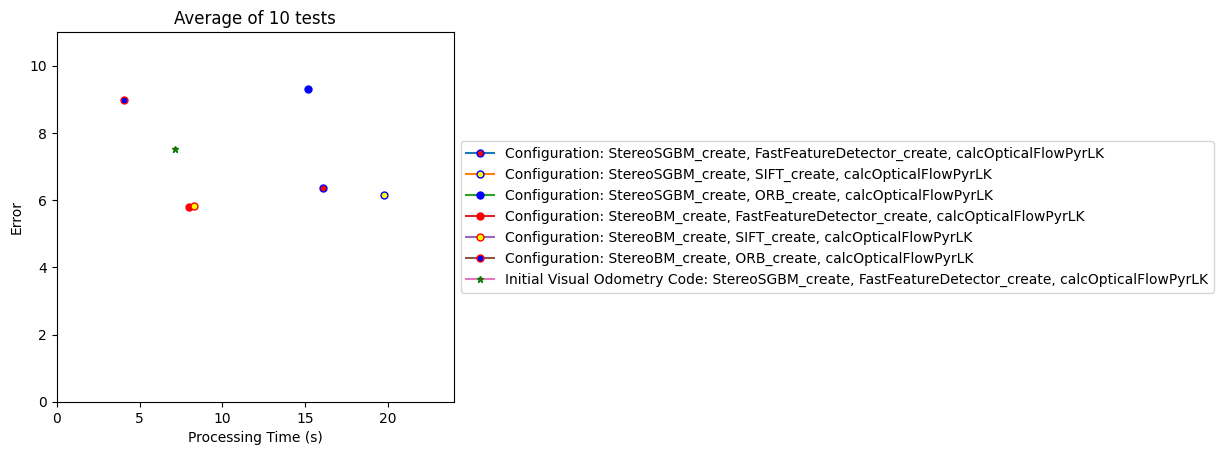

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(16.119963121414184, 6.350975403435621, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="red", label='Configuration: StereoSGBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK')
ax.plot(19.754355239868165, 6.1413348913309775, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="yellow", label='Configuration: StereoSGBM_create, SIFT_create, calcOpticalFlowPyrLK')
ax.plot(15.190055775642396, 9.307460022482612, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="blue", label='Configuration: StereoSGBM_create, ORB_create, calcOpticalFlowPyrLK')
ax.plot(7.999224257469177, 5.7997364114859495, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red", label='Configuration: StereoBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK')
ax.plot(8.3014395236969, 5.830624543303275, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="yellow", label='Configuration: StereoBM_create, SIFT_create, calcOpticalFlowPyrLK')
ax.plot(4.072988080978393, 8.981502178284801, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="blue", label='Configuration: StereoBM_create, ORB_create, calcOpticalFlowPyrLK')
ax.plot(7.161087155342102, 7.516704013332247, marker="*", markersize=5, markeredgecolor="green", markerfacecolor="red", label='Initial Visual Odometry Code: StereoSGBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK')


# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.xlim(0,24)
plt.ylim(0,11)
plt.title('Average of 10 tests')
plt.xlabel('Processing Time (s)')
plt.ylabel('Error')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()


### 100 Sample Test Comparison
Below is the same plot as above but over a 100 test samples. A majority of the outcomes did not change on this plot, but it was suprising to see that the processing time for the StereoBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK configuration significatly improved during this test. With this being a right to left change on the plot comparted to the original code, this is a definate improvement. 

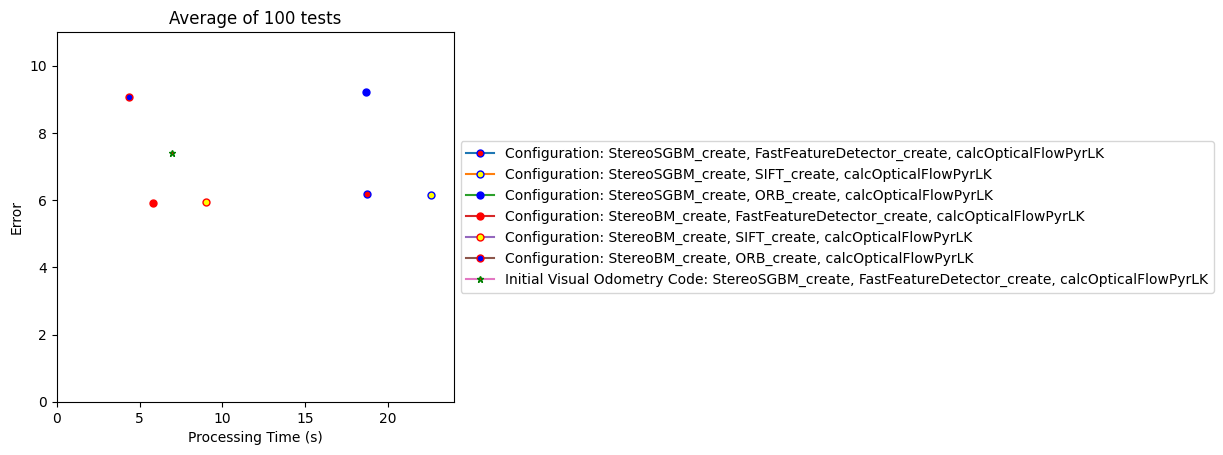

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.subplot(111)

ax.plot(18.735075240135192, 6.169205602228243, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="red", label='Configuration: StereoSGBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK')
ax.plot(22.618199272155763, 6.142365673054785, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="yellow", label='Configuration: StereoSGBM_create, SIFT_create, calcOpticalFlowPyrLK')
ax.plot(18.669941449165343, 9.220605285143089, marker="o", markersize=5, markeredgecolor="blue", markerfacecolor="blue", label='Configuration: StereoSGBM_create, ORB_create, calcOpticalFlowPyrLK')
ax.plot(5.81751008272171, 5.918917955327819, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="red", label='Configuration: StereoBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK')
ax.plot(9.033952720165253, 5.944351400325539, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="yellow", label='Configuration: StereoBM_create, SIFT_create, calcOpticalFlowPyrLK')
ax.plot(4.360996289253235, 9.060275375795975, marker="o", markersize=5, markeredgecolor="red", markerfacecolor="blue", label='Configuration: StereoBM_create, ORB_create, calcOpticalFlowPyrLK')
ax.plot(6.93410208940506, 7.3887397108363055, marker="*", markersize=5, markeredgecolor="green", markerfacecolor="red", label='Initial Visual Odometry Code: StereoSGBM_create, FastFeatureDetector_create, calcOpticalFlowPyrLK')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

plt.xlim(0,24)
plt.ylim(0,11)
plt.title('Average of 100 tests')
plt.xlabel('Processing Time (s)')
plt.ylabel('Error')
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

### Original Code Modified
Below is just a callable version of the orginal VO code that was used as the base for this project. The Github for this original code can be found here: https://github.com/niconielsen32/ComputerVision/tree/master/VisualOdometry. This code was modified slightly to allow use to iterate over multiple samples and output the same information as a base to campare the modifications. We turned off the animation for the original code for this test, but below is the original output for reference.

![Alt text](../Screen%20Captures%20and%20Videos/Original%20Code%20Output.jpg)

We have also added the monocular output as a reference as to why we chose to move forward with Stereo VO.

![Alt text](../Screen%20Captures%20and%20Videos/Original%20Code%20Mono%20Output.jpg)

#### Real-Time Simulation Validation
We did a sudo loop to validate the real-time code loop that we created worked. Below is the output that matches the obove expected plots. 

![Alt text](../Screen%20Captures%20and%20Videos/KITTI%20Simulated%20RealTime.jpg)

### Stereo Camera Calibration
Below is the code for stereo camera calibration to get the required camera projection matrices for the stereo camere we used for the real time test. The base for this code came from Temuge Batpurev at his Github site: https://temugeb.github.io/opencv/python/2021/02/02/stereo-camera-calibration-and-triangulation.html. The left and right camera projection matrices are printed after the code. This was updated in the real time code.


In [ ]:
from stereoVisionCalibration.stereoCamera_calibration import calibrate

calibrate()

P_l = [[513.09095763   0.         638.48875405   0.        ]
 [  0.         516.4312525  385.09645162   0.        ]
 [  0.           0.           1.           0.        ]]

P_r = [[ 5.11798374e+02 -8.68945779e+00  6.34137371e+02 -2.62564637e+03]
 [-4.09006205e-01  5.07552071e+02  3.74129706e+02 -2.47633173e+01]
 [ 1.92047943e-04 -1.44556056e-02  9.99895494e-01 -5.69633488e-02]]


#### Calibration Output Images
Below are the output images from the camera calibration using the checker board grid printout. 

![Alt text](../stereoVisionCalibration/images/Calib_Show%20Zed2.jpg)

### Real Time Test
Below is a couple of screen captures while doing a live test

![Alt text](../Screen%20Captures%20and%20Videos/Live_Demo_1.jpg)

![Alt text](../Screen%20Captures%20and%20Videos/Live_Demo_2.jpg)

![Alt text](../Screen%20Captures%20and%20Videos/Live_Demo_3.jpg)

Below is an output plot of moving forwards and backwards, the rotating forwards and backwards. 

![Alt text](../Screen%20Captures%20and%20Videos/Real%20Time%20Plot.jpg)
